In [1]:
import pandas as pd
import re
import string
import spacy
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop_words
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import emoji
from collections import Counter
import matplotlib.pyplot as plt
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException


In [2]:
!python -m spacy download fr_core_news_sm --break-system-packages
!pip install langdetect --break-system-packages
!pip install spacy nltk emoji

Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/urllib3/connection.py", line 198, in _new_conn
    sock = connection.create_connection(
        (self._dns_host, self.port),
    ...<2 lines>...
        socket_options=self.socket_options,
    )
  File "/usr/lib/python3/dist-packages/urllib3/util/connection.py", line 60, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
               ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.13/socket.py", line 977, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
               ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
socket.gaierror: [Errno -3] Temporary failure in name resolution

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/urllib3/connectionpool.py", line 787, in urlopen
    respo

In [3]:
try:
    nltk.download('stopwords', quiet=True)
    nltk.download('punkt', quiet=True)
except:
    print("Ressources NLTK déjà téléchargées")

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


In [4]:
#charger le dataset et regarder un peu comment il se presente

In [5]:
data = pd.read_csv("uvb_all.csv")
print(data.head() , data.info)

    Author                                              Tweet Date Link  \
0      NaN                                                NaN  NaN  NaN   
1  anonyme  Les cours sont intéressants mais parfois diffi...  NaN  NaN   
2  anonyme  Oui je pense que il ya des failles ! La connex...  NaN  NaN   
3  anonyme  L'université virtuelle du Burkina Faso, est un...  NaN  NaN   
4  anonyme                      Rien à dire! J'adore le UV-BF  NaN  NaN   

  Images  Retweets  Replies  Likes  Unnamed: 3 Unnamed: 4 langue  
0    NaN       NaN      NaN    NaN         NaN        NaN    NaN  
1    NaN       NaN      NaN    NaN         NaN        NaN    NaN  
2    NaN       NaN      NaN    NaN         NaN        NaN    NaN  
3    NaN       NaN      NaN    NaN         NaN        NaN    NaN  
4    NaN       NaN      NaN    NaN         NaN        NaN    NaN   <bound method DataFrame.info of          Author                                              Tweet  \
0           NaN                              

In [6]:
#checkons les champs vides

In [7]:
print(data.isnull().sum())

Author           1
Tweet            5
Date           323
Link           735
Images         735
Retweets       643
Replies        643
Likes          643
Unnamed: 3    1582
Unnamed: 4    1581
langue        1237
dtype: int64


In [8]:
#let's get started with managing date format

In [9]:
data.dtypes
print(data.columns)

Index(['Author', 'Tweet', 'Date', 'Link', 'Images', 'Retweets', 'Replies',
       'Likes', 'Unnamed: 3', 'Unnamed: 4', 'langue'],
      dtype='object')


In [10]:
#filter tweets for fr language
DetectorFactory.seed = 0
def detect_lang(text):
    try:
        return detect(str(text))
    except:
        return 'unknown'

data['langue'] = data['Tweet'].apply(detect_lang)


In [11]:
# Filtrer uniquement les tweets en français
data_fr = data[data['langue'] == 'fr'].copy()
data_fr.to_csv("data_francais.csv", index=False)
new_data = pd.read_csv("data_francais.csv")

In [12]:
print(new_data.info)
print(new_data.isnull().sum())


<bound method DataFrame.info of              Author                                              Tweet  \
0           anonyme  Les cours sont intéressants mais parfois diffi...   
1           anonyme  Oui je pense que il ya des failles ! La connex...   
2           anonyme  L'université virtuelle du Burkina Faso, est un...   
3           anonyme                      Rien à dire! J'adore le UV-BF   
4           anonyme  Formidable !  J'apprécie beaucoup ! Il n'y a p...   
..              ...                                                ...   
895         MIANSEH  #civedu Séance de travail à \n@uvciv\n avec un...   
896       konefode8  À tour de rôle, ça sent l'innovation de part e...   
897         MIANSEH  #civedu Après \n@UVT_tunisie\n, @UVS_Senegal e...   
898       AUF_AsieP  Les rencontres #IDNEUF4 : Le Pr Jean-Marie Dip...   
899  steevedecharme  Enseignement supérieur : Bientôt une universit...   

           Date                                               Link  \
0        

In [13]:

#cleaning the dataset

#drop useless columns
print(new_data.columns)
new_data.drop(columns=['Link','Images','Retweets','Replies','Likes','langue','Unnamed: 3', 'Unnamed: 4'], inplace=True)


#I decided right there to remove retweets, replies....;columns cause there are non valuables like 0 likes......and over half of the datas concerning them are missing
#check the dataset now
print("New columns after removing : ", new_data.columns)
new_data.dtypes


Index(['Author', 'Tweet', 'Date', 'Link', 'Images', 'Retweets', 'Replies',
       'Likes', 'Unnamed: 3', 'Unnamed: 4', 'langue'],
      dtype='object')
New columns after removing :  Index(['Author', 'Tweet', 'Date'], dtype='object')


Author    object
Tweet     object
Date      object
dtype: object

In [14]:
try:
    nlp_fr = spacy.load("fr_core_news_sm")
    print(" Modèle spaCy français chargé")
except OSError:
    print(" Modèle spaCy non trouvé. Exécutez: !python -m spacy download fr_core_news_sm")
    nlp_fr = None

 Modèle spaCy français chargé


In [15]:
class TweetPreprocessor:
    def __init__(self):
        # Stop words français + mots spécifiques aux réseaux sociaux
        self.stop_words = fr_stop_words.copy()
        custom_stop_words = {
            'rt', 'via', 'amp', 'http', 'https', 'www', 'com', 'org', 'fr',
            'like', 'follow', 'share', 'retweet', 'tweet', 'twitter', 'cc',
            'alors', 'donc', 'tout', 'tous', 'toute', 'toutes', 'être', 'avoir',
            'faire', 'dire', 'aller', 'voir', 'savoir', 'pouvoir', 'falloir',
            'vouloir', 'venir', 'devoir', 'prendre', 'donner', 'mettre', 'partir'
        }
        self.stop_words.update(custom_stop_words)
        
        # Stemmer français
        self.stemmer = SnowballStemmer('french')
        
        # spaCy pour lemmatisation
        self.nlp = nlp_fr
    
    def clean_tweet(self, text):
        """Nettoyage spécifique aux tweets"""
        if pd.isna(text):
            return ""
        
        text = str(text)
        
        # Supprimer les retweets "RT @user:"
        text = re.sub(r'^RT @\w+:', '', text)
        
        # Supprimer les URLs
        text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
        text = re.sub(r'www\.(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
        
        # Supprimer les mentions @username
        text = re.sub(r'@\w+', '', text)
        
        # Transformer hashtags (garder le texte, supprimer #)
        text = re.sub(r'#(\w+)', r'\1', text)
        
        # Supprimer les emojis
        text = self.remove_emojis(text)
        
        # Minuscules
        text = text.lower()
        
        # Supprimer ponctuation excessive
        text = re.sub(r'[^\w\s]', ' ', text)
        
        # Supprimer chiffres isolés
        text = re.sub(r'\b\d+\b', '', text)
        
        # Nettoyer espaces multiples
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    def remove_emojis(self, text):
        """Supprimer emojis"""
        # Pattern pour emojis Unicode
        emoji_pattern = re.compile("["
                                 u"\U0001F600-\U0001F64F"  # emoticons
                                 u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                 u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                 u"\U0001F1E0-\U0001F1FF"  # flags
                                 u"\U00002702-\U000027B0"
                                 u"\U000024C2-\U0001F251"
                                 "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r' ', text)
    
    def tokenize_and_lemmatize(self, text):
        """Tokenisation et lemmatisation avec spaCy"""
        if not text or not text.strip():
            return []
        
        if self.nlp:
            doc = self.nlp(text)
            tokens = []
            for token in doc:
                # Filtrer les tokens
                if (not token.is_stop and 
                    not token.is_punct and 
                    not token.is_space and
                    len(token.text) > 2 and
                    token.lemma_.lower() not in self.stop_words and
                    token.pos_ not in ['PRON', 'ADP', 'CCONJ', 'SCONJ', 'DET']):
                    tokens.append(token.lemma_.lower())
            return tokens
        else:
            # Fallback sans spaCy
            tokens = text.split()
            tokens = [t for t in tokens if len(t) > 2 and t not in self.stop_words]
            return [self.stemmer.stem(token) for token in tokens]
    
    def preprocess_tweet(self, text):
        """Pipeline complet"""
        cleaned = self.clean_tweet(text)
        tokens = self.tokenize_and_lemmatize(cleaned)
        return tokens, ' '.join(tokens)



In [16]:
df = pd.read_csv("data_cleaned.csv")

# Initialiser le preprocessor
preprocessor = TweetPreprocessor()

# Appliquer le preprocessing
df['tweet_cleaned'] = df['Tweet'].apply(preprocessor.clean_tweet)
tweets_processed = df['Tweet'].apply(preprocessor.preprocess_tweet)

# Séparer tokens et texte final
df['tokens'] = tweets_processed.apply(lambda x: x[0])
df['text_final'] = tweets_processed.apply(lambda x: x[1])

# Filtrer les tweets vides après preprocessing
df_final = df[df['text_final'].str.len() > 0].copy()


Nombre moyen de tokens par tweet: 29.42
Médiane: 19


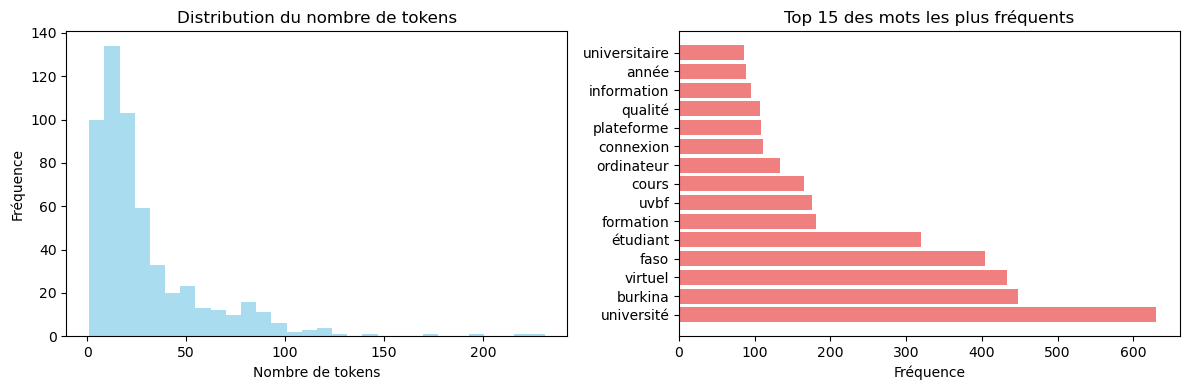

In [17]:

# Distribution longueur des tweets
df_final['nb_tokens'] = df_final['tokens'].apply(len)
print(f"Nombre moyen de tokens par tweet: {df_final['nb_tokens'].mean():.2f}")
print(f"Médiane: {df_final['nb_tokens'].median():.0f}")

# Visualisation
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df_final['nb_tokens'], bins=30, alpha=0.7, color='skyblue')
plt.title('Distribution du nombre de tokens')
plt.xlabel('Nombre de tokens')
plt.ylabel('Fréquence')

# Top mots les plus fréquents
all_tokens = [token for tokens in df_final['tokens'] for token in tokens]
most_common = Counter(all_tokens).most_common(20)

plt.subplot(1, 2, 2)
words, counts = zip(*most_common[:15])
plt.barh(range(len(words)), counts, color='lightcoral')
plt.yticks(range(len(words)), words)
plt.title('Top 15 des mots les plus fréquents')
plt.xlabel('Fréquence')

plt.tight_layout()
plt.show()
